<a href='https://ai.meng.duke.edu'>
  <img align="left" style="padding-top:10px;" src="https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png">
</a>




### **Problem Statement / Description of Dataset**

The objective of this course project is to develop predictive models—both a traditional regression model and a deep neural network (DNN)—to estimate key nuclear reactor physics parameters:

- **Infinite Multiplication Factor (k-inf)**: A measure of neutron economy in an infinite reactor lattice.

These parameters are modeled as functions of varying enrichment levels of uranium-235 (U-235) across fuel pins in a reactor fuel assembly. The dataset was sourced from the UCI Machine Learning Repository and consists of synthetic data generated via Monte Carlo N-Particle Transport Code (MCNP6) simulations for the NuScale US600 fuel assembly design (NFAC-01). The MCNP6 code is widely used in Nuclear Engineering to model the behaviour of nuetron flux. Each of the 39 rods were assigned a random U-235 enrichment with 24000 samples generated. 

The goal is to build models capable of accurately predicting k-inf from enrichment configurations, enabling faster evaluations for fuel design and safety analysis.

Huu Tiep, N. (2024). Lattice-physics (PWR fuel assembly neutronics simulation results) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5BK64.


### **Background**

It is no secret that the accessibility of GPUs helped thaw the AI winter, enabling the development of deep neural networks and sparking an AI revolution that has inevitably reached the energy sector. The exponential rise in investments in energy infrastructure to support advanced computations highlights the growing demand for alternative energy solutions. As the climate crisis intensifies and global energy demands increase, the urgency for high power density technologies becomes clear.

Recent efforts to integrate AI and machine learning (ML) into the nuclear energy domain have expanded the application of these tools across Nuclear Engineering. This project exemplifies how ML algorithms can assist nuclear engineers in identifying optimal uranium enrichment levels in reactor cores to ensure thermal safety margins are not violated.

Most plants use either a pressurized water reactor (PWR) and boiling water reactors (BWR) respectfully. Pressurized water reactors provide heat transfer via a primary loop pressurized to 2000 psig. This water then heats water in a steam generator that further spins turbines for electricity generation.

One key parameter—**Infinite Multiplication Factor (k-inf)**-serves as target variables in this project, as they are directly linked to the safety and efficiency of reactor core designs. The lattice structure and fuel enrichment distribution play critical roles in determining these characteristics:

- If **k-inf > 1.0**, the reactor is **supercritical**  
- If **k-inf = 1.0**, the reactor is **critical**  
- If **k-inf < 1.0**, the reactor is **subcritical**


 These models can help engineers iterate on safe core designs without the exhaustive burden of traditional computational simulations.


In [3]:
# Let's begin by importing the necessary dependencies for data loading, data scrubbing, exploratory data analysis and feature engineering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Let's read-in the data and take a priliminary look

nuk_data=pd.read_csv ('raw.csv', header=None, delim_whitespace=True)
print(nuk_data.shape)
nuk_data.head()

C:\Users\brian\AppData\Local\Temp\ipykernel_21484\2358489696.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nuk_data=pd.read_csv ('raw.csv', header=None, delim_whitespace=True)


(24000, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1.32630,1.862086,3.562615,1.112359,4.208065,1.412679,2.271031,3.950614,3.627032,4.600332,...,3.965987,4.030999,0.826347,2.088521,4.088550,1.184149,2.780985,2.865400,4.773820,3.539373
1,1.34149,1.786558,2.354766,1.047929,2.268974,4.637777,3.793194,2.859702,4.361058,3.592485,...,2.228000,4.837370,2.846538,3.413201,4.154079,4.700800,3.597879,4.681148,3.215494,3.972672
2,1.33034,1.826187,3.037997,4.719517,1.502280,3.644736,3.575727,1.337686,2.380347,4.503771,...,2.615278,3.757999,3.161658,4.996056,3.339642,2.548468,4.417111,1.375554,4.363320,2.988546
3,1.35653,1.739225,4.412804,2.220680,3.132738,1.327124,4.759890,2.882082,3.663430,4.531524,...,3.899026,1.018926,4.379308,3.280298,3.916281,3.179922,3.769315,0.849544,2.508179,0.912272
4,1.30190,1.955829,2.790669,0.798177,1.231750,1.977844,2.393930,4.738126,1.364743,3.391665,...,3.641512,1.564076,2.178406,2.754888,4.007165,0.702069,4.064682,1.370575,0.769475,1.395959


**At first glance, we see the data does not have any column names. This will be a problem so let's correct now.**

In [5]:
fuel_pin_columns = [f'fuel_pin_{i}' for i in range(1, 40)]  
column_names = fuel_pin_columns + ['Kinf', 'PPPF']          
nuk_data.columns = column_names
nuk_data.head()


,fuel_pin_1,fuel_pin_2,fuel_pin_3,fuel_pin_4,fuel_pin_5,fuel_pin_6,fuel_pin_7,fuel_pin_8,fuel_pin_9,fuel_pin_10,...,fuel_pin_32,fuel_pin_33,fuel_pin_34,fuel_pin_35,fuel_pin_36,fuel_pin_37,fuel_pin_38,fuel_pin_39,Kinf,PPPF
0,1.32630,1.862086,3.562615,1.112359,4.208065,1.412679,2.271031,3.950614,3.627032,4.600332,...,3.965987,4.030999,0.826347,2.088521,4.088550,1.184149,2.780985,2.865400,4.773820,3.539373
1,1.34149,1.786558,2.354766,1.047929,2.268974,4.637777,3.793194,2.859702,4.361058,3.592485,...,2.228000,4.837370,2.846538,3.413201,4.154079,4.700800,3.597879,4.681148,3.215494,3.972672
2,1.33034,1.826187,3.037997,4.719517,1.502280,3.644736,3.575727,1.337686,2.380347,4.503771,...,2.615278,3.757999,3.161658,4.996056,3.339642,2.548468,4.417111,1.375554,4.363320,2.988546
3,1.35653,1.739225,4.412804,2.220680,3.132738,1.327124,4.759890,2.882082,3.663430,4.531524,...,3.899026,1.018926,4.379308,3.280298,3.916281,3.179922,3.769315,0.849544,2.508179,0.912272
4,1.30190,1.955829,2.790669,0.798177,1.231750,1.977844,2.393930,4.738126,1.364743,3.391665,...,3.641512,1.564076,2.178406,2.754888,4.007165,0.702069,4.064682,1.370575,0.769475,1.395959


**We have the columns appropriately named. As shown above, each column represents a different fuel pin with a randomized Uranium enrichment. Let's move on to some EDA**

In [6]:
nuk_data[['Kinf','PPPF']].describe () #This will give some overall stats such as mean, median, mode etc

,Kinf,PPPF
count,24000.000000,24000.000000
mean,2.851978,2.851249
std,1.237966,1.246842
min,0.700101,0.700251
25%,1.775471,1.765346
50%,2.855193,2.848884
75%,3.916448,3.932423
max,4.999340,4.999952


**The descriptive statitics cause some pause. The infinite multiplication factor is much higher than expected. Most cores fluctuate to have anywhere between 1.0-1.5 Keff/inf. The results suggest highly reactive cores. Something that warrants further investigation.**

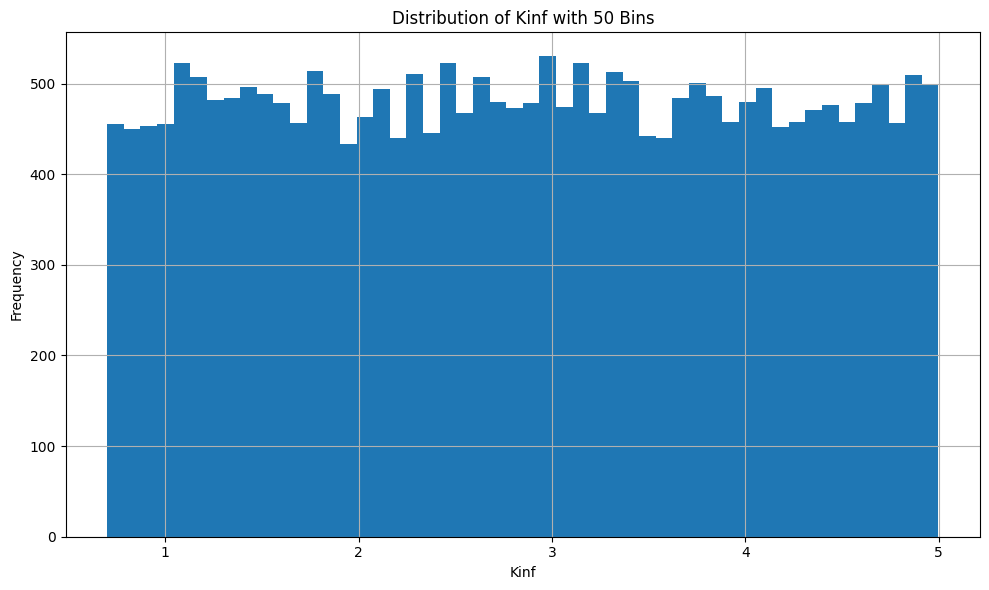

In [7]:
nuk_data['Kinf'].hist(bins=50, figsize=(10, 6))
plt.xlabel('Kinf')
plt.ylabel('Frequency')
plt.title('Distribution of Kinf with 50 Bins')
plt.tight_layout()
plt.show()





**There may be more reasons that we are not seeing a normal distribution. It could very well be preprocessing needs to be completed or other features are not being considered such as average coolant temperature.**

**Since we have no categorical data, no one hot encoding is necessary. Let's move on to building our Linear Regression Model.**

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
#define our variables
nuk_data.columns = nuk_data.columns.str.strip()

X=nuk_data.drop(['Kinf'], axis=1)
y=nuk_data['Kinf']


In [24]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Scale the features
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

print("Data is adequately scaled and prepared for training.")

# Instantiate and train the model
model = LinearRegression()
trained_model = model.fit(X_train_scaled, y_train)

print("Model trained, now let's test")

# Transform the test data and make predictions
X_test_scaled = sc.transform(X_test)
y_preds = model.predict(X_test_scaled)

# Evaluate the model
MAE = mean_absolute_error(y_test, y_preds)
MSE= mean_squared_error(y_test, y_preds)

r2=r2_score(y_test,y_preds)


print(f"The Linear Regression model for predicting Kinf on Uranium 235 loading for 24000 theoretical cores has a MAE of {MAE:.3f}, a MSE of {MSE:.3f} and a Regression score of {r2:.3f}")


Data is adequately scaled and prepared for training.
Model trained, now let's test
The Linear Regression model for predicting Kinf on Uranium 235 loading for 24000 theoretical cores has a MAE of 0.568, a MSE of 0.527 and a Regression score of 0.664


**The accuracy for this model is not nearly what it should be to be considered for a viable use. But we need to explore why. Let's determine if we first reduce any features that are causing noise, if collinearity exist and then adjust.**

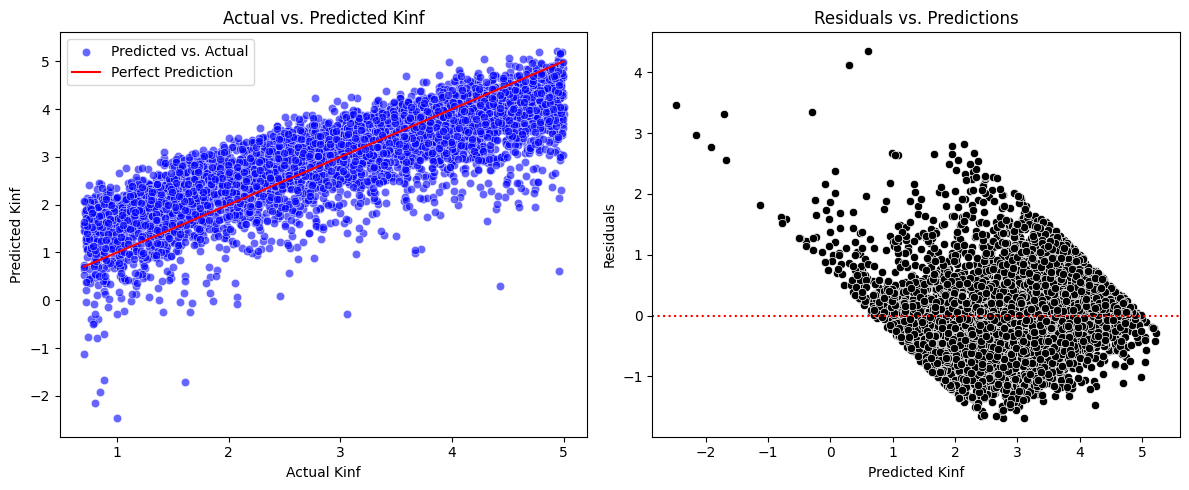

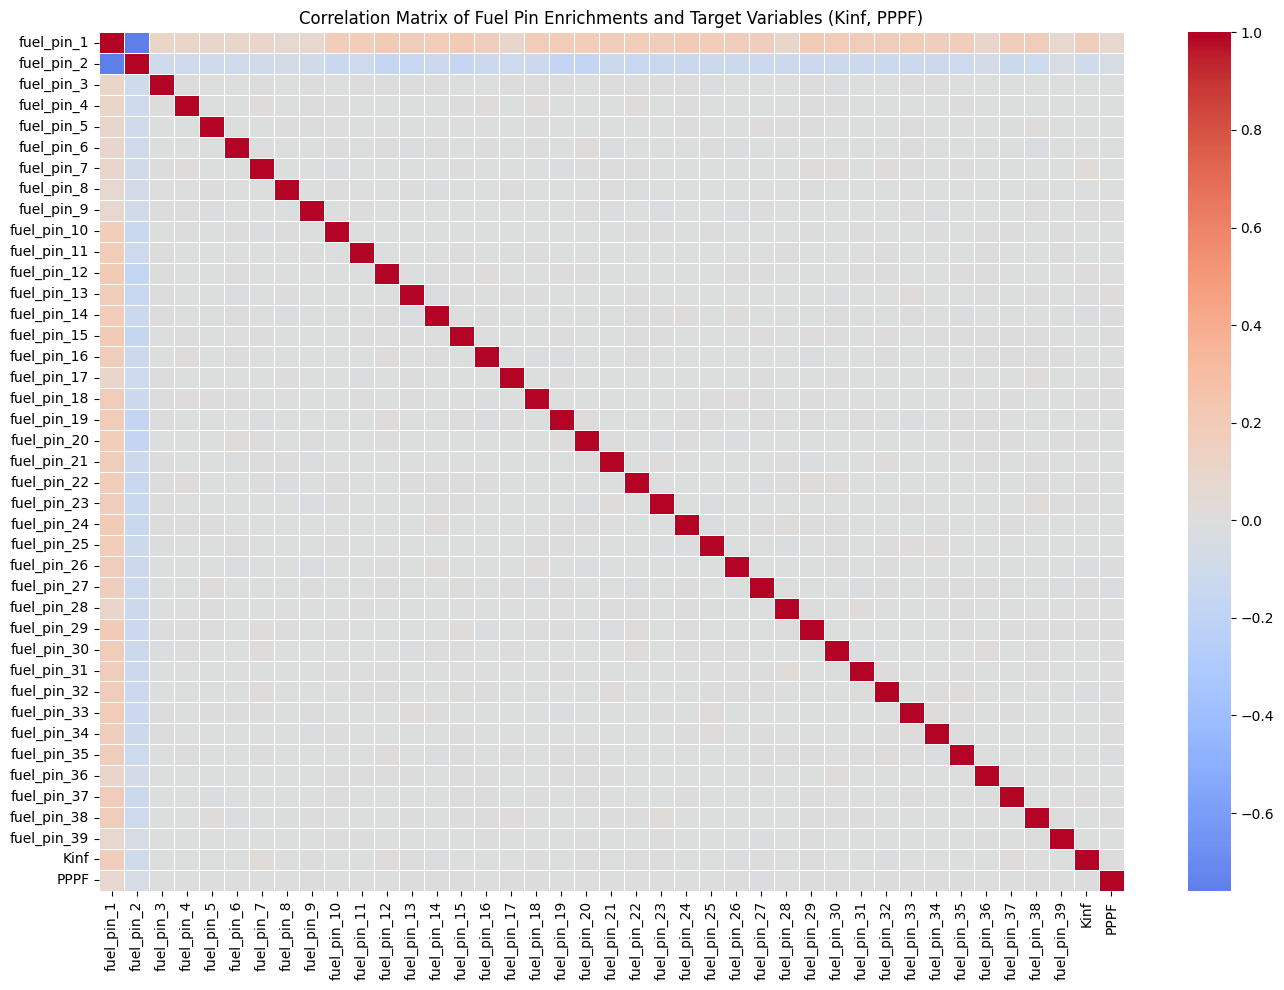

In [11]:
plt.figure(figsize=(12, 5))

# Scatterplot: Actual vs Predicted Kinf
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_preds, color="blue", alpha=0.6, label="Predicted vs. Actual")
sns.lineplot(x=y_test, y=y_test, color="red", label="Perfect Prediction")  # reference line
plt.xlabel("Actual Kinf")
plt.ylabel("Predicted Kinf")
plt.title("Actual vs. Predicted Kinf")
plt.legend()

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_preds
sns.scatterplot(x=y_preds, y=residuals, color="black")
plt.axhline(y=0, color="red", linestyle=":")
plt.xlabel("Predicted Kinf")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predictions")

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = nuk_data.corr()

sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of Fuel Pin Enrichments and Target Variables (Kinf, PPPF)")
plt.tight_layout()
plt.show()


**From the above we can deduce that collinearity is not an issue with this dataset; it would make sense considering where this dataset was sourced from. Residuals are randomly scattered and therefore do not exibit the patterns associated with multicollinearity. To reduce error that's continue with PCA.**

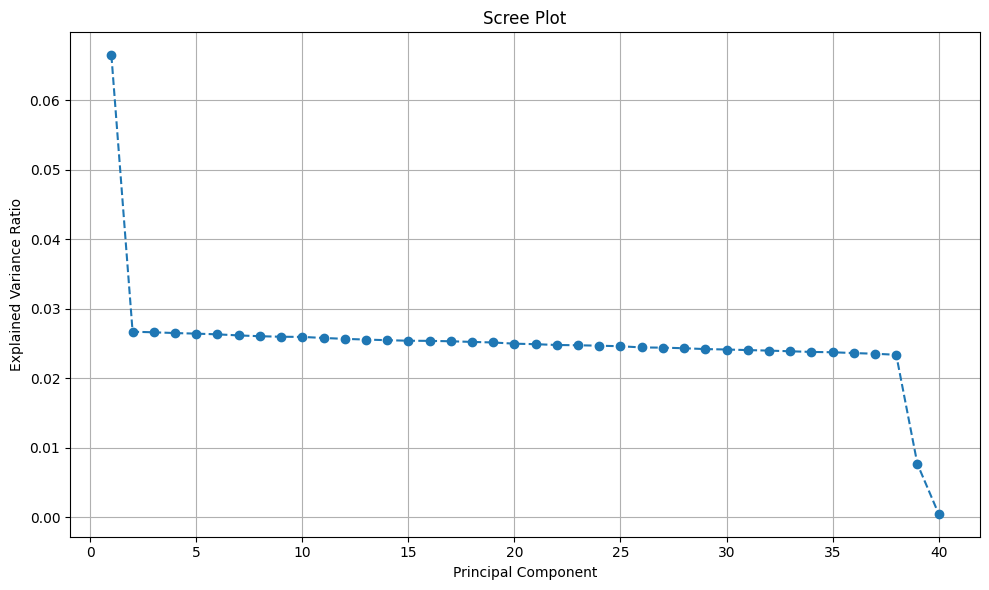

In [12]:
# Apply PCA without limiting components (full PCA)
from sklearn.decomposition import PCA

pca_full = PCA()
X_scaled_full = sc.fit_transform(X)  
pca_full.fit(X_scaled_full)

# Plot Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
         pca_full.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

**The above demonstrates that all components are needed to increase the accuracy of our predictions. Since collinearity and noise are not an issue, it makes since principle component analysis you not reduce the number of features.**

In [13]:
from sklearn.linear_model import Lasso

alphas = np.logspace(-4, 0, 100)

best_alpha = None
lowest_mae = float('inf')

# Loop through each alpha
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)

    if mae < lowest_mae:
        lowest_mae = mae
        best_alpha = alpha

# Refit model with best alpha
best_model = Lasso(alpha=best_alpha, max_iter=10000)
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best alpha: {best_alpha:.5f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Best alpha: 0.00010
MAE: 0.5612
MSE: 0.5045
R² Score: 0.6735


In [14]:
from sklearn.linear_model import Ridge

alphas = np.logspace(-4, 0, 100)

best_alpha = None
lowest_mae = float('inf')


for alpha in alphas:
    model = Ridge(alpha=alpha, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)

    if mae < lowest_mae:
        lowest_mae = mae
        best_alpha = alpha


best_model = Ridge(alpha=best_alpha, max_iter=10000)
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best alpha: {best_alpha:.5f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Best alpha: 0.00010
MAE: 0.5610
MSE: 0.5045
R² Score: 0.6735


**After exploring Linear Regression, LASSO, and Ridge models, it has become apparent that the lack of collinearity amongst the features does not render one of the above models better apt for this problem than the other. The last algorithm I'd like to try is support vector regression**

In [15]:
from sklearn import svm

svm_reg=svm.SVR()

nuk_data_regressor=svm_reg.fit(X_train_scaled,y_train)

y_pred=nuk_data_regressor.predict(X_test_scaled)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE: 0.3248
MSE: 0.1702
R² Score: 0.8898


**As seen above, we see a marked difference when employing SVMs to develop a more accurate algorithm. But we should seek some level of optimization here. SVMs use a margin determined by hyperparameter C. The higher C is, the less forgiving the model is to mistakes. Let's iterate through to find the best hyper parameters to lower our error even further.**

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    
'C': np.logspace(-3, 2, 6),
'epsilon': [0.01, 0.05, 0.1, 0.2],
'kernel': ['linear'],
}

svm_reg=svm.SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best SVR Params: {grid_search.best_params_}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Best SVR Params: {'C': 10.0, 'epsilon': 0.2, 'kernel': 'linear'}
MAE: 0.5617
MSE: 0.5336
R² Score: 0.6481


**This concludes building shallow regression algorithms. From seen above, SVM was the optimal algorithm to employ with errors far lower than Linear, LASSO and RIDGE regression. It is important to note the computational cost associated with SVM when using GridSearch for optimization. The default hyperparameters we're far less costly. Because the data was largely synthetic (the montecarlo code was used to generate the PPPF and Kinf), we see that collinearity was not an issue. For further exploration, I would include other features that impact reactor dynamics than just uranium enrichment. If a dataset was used that incorporated rod height, temperatures, pressures AND enrichment, we would have seen correlations between features which would have neccessitated polynomial regression and the kernel trick (RBF, poly) for SVR.**

**For the next portion of model development, we will build, from scratch, a multi-layer perceptron nueral network capable of predicting the Kinf from the dataset. We will use TensorFlow 2.0 and the Keras API to run TensorFlow scripts on Python**

In [17]:
#Let's determine the actual tensorflow version

import tensorflow as tf

print(tf.__version__)

2.19.0


In [18]:
from tensorflow.keras.layers import Dense, Dropout, Activation

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [23]:
#Let's start building a model from scratch using Numpy. This will be a regression problem so the output function will be linear

class NeuralNetFromScratch:
    def __init__(self, eta=0.01, n_iter=5000, hidden_size=64, random_state=42):
        self.eta = eta 
        self.n_iter = n_iter  
        self.hidden_size = hidden_size  
        np.random.seed(random_state)

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def fit(self, X, y):
        N, P = X.shape
        y = np.array(y).reshape(-1, 1)


        # Initialize weights and biases
        self.W1 = np.random.randn(P, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, 1) * 0.01
        self.b2 = np.zeros((1, 1))

        for i in range(self.n_iter):
            # Forward pass
            Z1 = X @ self.W1 + self.b1
            A1 = self.relu(Z1)
            Z2 = A1 @ self.W2 + self.b2
            y_hat = Z2  # Linear activation for regression

            # Compute MSE loss
            loss = np.mean((y_hat - y) ** 2)

            # Backward pass
            dZ2 = 2 * (y_hat - y) / N
            dW2 = A1.T @ dZ2
            db2 = np.sum(dZ2, axis=0, keepdims=True)

            dA1 = dZ2 @ self.W2.T
            dZ1 = dA1 * self.relu_derivative(Z1)
            dW1 = X.T @ dZ1
            db1 = np.sum(dZ1, axis=0, keepdims=True)

            # Gradient descent update
            self.W1 -= self.eta * dW1
            self.b1 -= self.eta * db1
            self.W2 -= self.eta * dW2
            self.b2 -= self.eta * db2

            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss:.4f}")

        return self

    def predict(self, X):
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        return Z2  # Linear output for regression


In [31]:
nn = NeuralNetFromScratch(eta=0.01, n_iter=5000, hidden_size=64)
nn.fit(X_train_scaled, y_train)
y_pred = nn.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


Epoch 0, Loss: 9.6872
Epoch 100, Loss: 1.5565
Epoch 200, Loss: 1.4832
Epoch 300, Loss: 1.4494
Epoch 400, Loss: 1.4069
Epoch 500, Loss: 1.3483
Epoch 600, Loss: 1.2642
Epoch 700, Loss: 1.1470
Epoch 800, Loss: 1.0016
Epoch 900, Loss: 0.8504
Epoch 1000, Loss: 0.7178
Epoch 1100, Loss: 0.6149
Epoch 1200, Loss: 0.5399
Epoch 1300, Loss: 0.4858
Epoch 1400, Loss: 0.4450
Epoch 1500, Loss: 0.4125
Epoch 1600, Loss: 0.3863
Epoch 1700, Loss: 0.3657
Epoch 1800, Loss: 0.3492
Epoch 1900, Loss: 0.3351
Epoch 2000, Loss: 0.3217
Epoch 2100, Loss: 0.3085
Epoch 2200, Loss: 0.2957
Epoch 2300, Loss: 0.2838
Epoch 2400, Loss: 0.2728
Epoch 2500, Loss: 0.2626
Epoch 2600, Loss: 0.2531
Epoch 2700, Loss: 0.2442
Epoch 2800, Loss: 0.2362
Epoch 2900, Loss: 0.2290
Epoch 3000, Loss: 0.2224
Epoch 3100, Loss: 0.2163
Epoch 3200, Loss: 0.2104
Epoch 3300, Loss: 0.2047
Epoch 3400, Loss: 0.1992
Epoch 3500, Loss: 0.1940
Epoch 3600, Loss: 0.1891
Epoch 3700, Loss: 0.1845
Epoch 3800, Loss: 0.1801
Epoch 3900, Loss: 0.1759
Epoch 4000, 

**Clearly training a deep nueral network using 5000 passthrough and a linear activation function yielded the best results. We used a linear model and a cost function of MSE. We then used gradient descent to optimize our weights. This was calculated finding the partial derivative of the cost function with respect to w. We used Numpy for this nueral network. Now I'll use tensor flow and Keras to see if we can optimize it further**

In [32]:
def Nuk_regression_model(learning_rate, dropout_rate):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))  
    
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae', 'mse'])
    return model


In [43]:
# Build the model
Nuk_deep_model = Nuk_regression_model(learning_rate=0.001, dropout_rate=0.1)

# Train the model
Nuk_deep_model.fit(X_train_scaled, y_train, epochs=100, verbose=1)

# Predict on the test set
y_pred = Nuk_deep_model.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Epoch 1/100


C:\Users\brian\OneDrive\Duke\AIPI 520\Course Project\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.2357 - mae: 1.2316 - mse: 2.2357
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4363 - mae: 1.0124 - mse: 1.4363
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0114 - mae: 0.8343 - mse: 1.0114
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5332 - mae: 0.5826 - mse: 0.5332
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3730 - mae: 0.4815 - mse: 0.3730
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3122 - mae: 0.4373 - mse: 0.3122
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2804 - mae: 0.4139 - mse: 0.2804
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2571 - mae: 0.3949 - mse: 0.2571
Epoch 9/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2420 - mae: 0.3828 - mse: 0.2420
Epoch 10/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2254 - mae: 0.3700 - mse: 0.2254
Epoch 11/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1172 - mae: 0.2689 - mse: 0.1172
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1186 - mae: 0.2706 - mse: 0.1186
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1168 - mae: 0.2665 - mse: 0.1168
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1198 - mae: 0.2721 - mse: 0.1198
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1168 - mae: 0.2672 - mse: 0.1168
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1201 - mae: 0.2710 - mse: 0.1201
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1189 - mae: 0.2701 - mse: 0.1189
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1203 - mae: 0.2725 - mse: 0.1203
Epoch 9/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1141 - mae: 0.2658 - mse: 0.1141
Epoch 10/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1150 - mae: 0.2658 - mse: 0.1150
Epoch 11/100
600/600 ━━━━━━━━━━━━━━━━━━

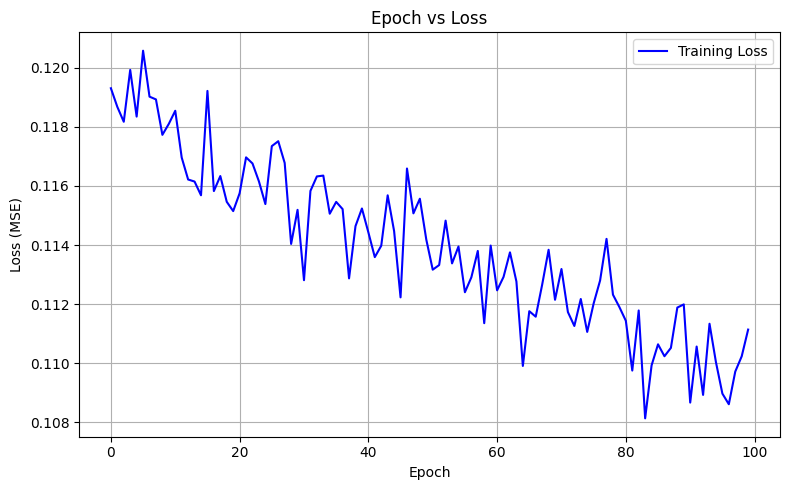

In [46]:


# Train and store history
history = Nuk_deep_model.fit(X_train_scaled, y_train, epochs=100, verbose=1)

# Plot loss vs epoch
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Let's determine if adjusting the number of hidden layers has an impact on overall error**

In [21]:
def Nuk_regression_model(layer_units, learning_rate=0.001, dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(layer_units[0], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))

    for units in layer_units[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae', 'mse'])

    return model

layer_configs = [
    [64, 32],
    [128, 64, 32],
    [64, 64, 64]
]

for config in layer_configs:
    print(f"Training model with layers: {config}")
    model = Nuk_regression_model(config, learning_rate=0.001, dropout_rate=0.1)
    model.fit(X_train_scaled, y_train, epochs=100, verbose=1)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}\n")


Training model with layers: [64, 32]
Epoch 1/100


C:\Users\brian\OneDrive\Duke\AIPI 520\Course Project\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.7222 - mae: 1.5252 - mse: 3.7222
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4197 - mae: 0.9962 - mse: 1.4197
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0456 - mae: 0.8462 - mse: 1.0456
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5925 - mae: 0.6150 - mse: 0.5925
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4010 - mae: 0.4982 - mse: 0.4010
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3339 - mae: 0.4516 - mse: 0.3339
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2955 - mae: 0.4233 - mse: 0.2955
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2791 - mae: 0.4120 - mse: 0.2791
Epoch 9/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2682 - mae: 0.3996 - mse: 0.2682
Epoch 10/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2422 - mae: 0.3815 - mse: 0.2422
Epoch 11/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/st

C:\Users\brian\OneDrive\Duke\AIPI 520\Course Project\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.2156 - mae: 1.2146 - mse: 2.2156
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1530 - mae: 0.8864 - mse: 1.1530
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5899 - mae: 0.6105 - mse: 0.5899
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3932 - mae: 0.4904 - mse: 0.3932
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3125 - mae: 0.4362 - mse: 0.3125
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2631 - mae: 0.4008 - mse: 0.2631
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2513 - mae: 0.3886 - mse: 0.2513
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2271 - mae: 0.3694 - mse: 0.2271
Epoch 9/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2053 - mae: 0.3506 - mse: 0.2053
Epoch 10/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2039 - mae: 0.3500 - mse: 0.2039
Epoch 11/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

C:\Users\brian\OneDrive\Duke\AIPI 520\Course Project\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.1583 - mae: 1.2021 - mse: 2.1583
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4194 - mae: 1.0038 - mse: 1.4194
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9860 - mae: 0.8151 - mse: 0.9860
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5529 - mae: 0.5917 - mse: 0.5529
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4008 - mae: 0.4981 - mse: 0.4008
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3247 - mae: 0.4466 - mse: 0.3247
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2888 - mae: 0.4191 - mse: 0.2888
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2651 - mae: 0.4019 - mse: 0.2651
Epoch 9/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2401 - mae: 0.3800 - mse: 0.2401
Epoch 10/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2149 - mae: 0.3637 - mse: 0.2149
Epoch 11/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

### Comparison of Different Neural Network Architectures

I looped through three different architectures to determine how depth and layer uniformity impacted model performance. As seen above, the model that lacked uniformity and had the most depth outperformed the others. Starting out with a large amount of nodes and narrowing towards the final layer gave the best results.

The **[128, 64, 32]** architecture demonstrated the best predictive performance, achieving the lowest MAE and MSE, and the highest R² score [MAE: 0.2269, MSE: 0.0829, R²: 0.9463]. 


### After comparing different algorithms, it is clear that the ANN was the winner in producing a model with the least amount of error. Linear Regression was the most computationally inexpensive but had the highest error. Which, given the application of this model in Nuclear Engineering, is unacceptable. What was unusual was that the Support Vector Machine was the most computationally expensive of all the models and produced marginally better results than the other shallow algorithms. Overall the ANN with a 128,64,32 architecture was the best model in predicting the infinite multiplication factor given a set of fuel rods enriched to a certain percent.